In [6]:
from dataclasses import replace
import random
from collections import Counter
import pandas as pd

from replenishment import (
    build_point_forecast_article_configs_from_standard_rows,
    build_replenishment_decisions_from_simulations,
    compute_backtest_rmse_by_article,
    generate_standard_simulation_rows,
    optimize_aggregation_and_service_level_factors,
    optimize_service_level_factors,
    plot_replenishment_decisions,
    replenishment_decision_rows_to_dataframe,
    simulate_replenishment_for_articles,
    simulate_replenishment_with_aggregation,
    split_standard_simulation_rows,
    standard_simulation_rows_to_dataframe,
)

### Policy cadence parameters (review cycle + forecast horizon)

Set the order cadence (**review_period**) and the coverage window (**forecast_horizon**, excluding lead time).
The policy uses a total horizon of **lead_time + forecast_horizon**.


In [7]:
review_period = 1
forecast_horizon = 1
rmse_window = review_period  # optional; defaults to review_period


# Mean Forecast: Fill Rate
This notebook treats `sigma` as a probability (cycle fill rate) and compares:  
1) optimizing sigma only,  
2) optimizing sigma + aggregation window.


## 1) Generate Sample Data
We generate synthetic history + forecast rows. Forecast periods are given simulated actuals so we can compare forecast vs. actuals in evaluation.


In [8]:

history_mean = 20.0
history_std = 8.0
forecast_mean = 18.0
forecast_std = 6.0

rows = generate_standard_simulation_rows(
    n_unique_ids=200,
    periods=120,
    history_mean=history_mean,
    history_std=history_std,
    forecast_mean=forecast_mean,
    forecast_std=forecast_std,
    forecast_start_period=60,
    lead_time=3,    
    initial_on_hand=25,
    current_stock=25,
    holding_cost_per_unit=1,
    stockout_cost_per_unit=5,
    order_cost_per_order=10,
)

backtest_rows, evaluation_rows = split_standard_simulation_rows(rows)

# Add simulated actuals for the forecast/evaluation period.
rng = random.Random(7)
def _sample_int(mean: float, std: float) -> int:
    return max(0, int(round(rng.gauss(mean, std))))

evaluation_rows_actuals = []
for row in evaluation_rows:
    actual = _sample_int(history_mean, history_std)
    evaluation_rows_actuals.append(replace(row, actuals=actual, demand=actual))

evaluation_rows = evaluation_rows_actuals

rows_df = standard_simulation_rows_to_dataframe(
    backtest_rows + evaluation_rows, library="pandas"
)
print(f"backtest rows: {len(backtest_rows)}, forecast rows: {len(evaluation_rows)}")
if not evaluation_rows:
    raise ValueError("No forecast rows found. Set forecast_start_period to create forecast rows.")

candidate_service_levels = [.1, .12, .14, .16, .18, .2, .22, .24, .26, .28, .3, .32, .34, .36, .38, .4, .42,  .5, 
                       .6, .62, .64, .66, .68, 0.7, .72, .74, .76, 
                       .78, 0.8, .82, .84, .86, .88, .90, .92, .94, .96, .99
                       ]
candidate_windows = [3, 6, 9]


backtest rows: 12000, forecast rows: 12000


## 2) Optimize Sigma Only (Fill Rate)


In [9]:
backtest_rmse = compute_backtest_rmse_by_article(backtest_rows, rmse_window=rmse_window)

point_configs = build_point_forecast_article_configs_from_standard_rows(
    backtest_rows,
    service_level_factor=candidate_service_levels[0],
    service_level_mode="fill_rate",
    fixed_rmse=backtest_rmse,
    review_period=review_period,
    forecast_horizon=forecast_horizon,
    rmse_window=rmse_window,
)

optimized = optimize_service_level_factors(
    point_configs,
    candidate_factors=candidate_service_levels,
    service_level_mode="fill_rate",
)

best_factors = {
    unique_id: result.service_level_factor
    for unique_id, result in optimized.items()
}

backtest_actuals = {}
for row in backtest_rows:
    backtest_actuals.setdefault(row.unique_id, []).append(row)
for unique_id, series in backtest_actuals.items():
    series.sort(key=lambda r: r.ds)
    backtest_actuals[unique_id] = [int(r.actuals) for r in series]

eval_configs = build_point_forecast_article_configs_from_standard_rows(
    evaluation_rows,
    service_level_factor=best_factors,
    service_level_mode="fill_rate",
    fixed_rmse=backtest_rmse,
    actuals_override=backtest_actuals,
    review_period=review_period,
    forecast_horizon=forecast_horizon,
    rmse_window=rmse_window,
)
eval_simulations = simulate_replenishment_for_articles(eval_configs)
eval_decisions = build_replenishment_decisions_from_simulations(
    evaluation_rows,
    eval_simulations,
    sigma=best_factors,
    fixed_rmse=backtest_rmse,
    service_level_mode="fill_rate",
    review_period=review_period,
    forecast_horizon=forecast_horizon,
    rmse_window=rmse_window,
)


## Calibration: pick fill-rate factor that hits a target on backtest
We simulate each candidate factor on the backtest and select the one that produces a realized
fill rate closest to the target (per SKU). This aligns the policy with the desired service level.


In [10]:
target_fill_rate = 0.95

calibration_rows = []
calibrated_factors = {}

for factor in candidate_service_levels:
    calib_configs = build_point_forecast_article_configs_from_standard_rows(
        backtest_rows,
        service_level_factor=factor,
        service_level_mode="fill_rate",
        fixed_rmse=backtest_rmse,
        review_period=review_period,
        forecast_horizon=forecast_horizon,
        rmse_window=rmse_window,
    )
    calib_sims = simulate_replenishment_for_articles(calib_configs)
    for uid, sim in calib_sims.items():
        realized = sim.summary.fill_rate
        diff = abs(realized - target_fill_rate)
        calibration_rows.append(
            {
                "unique_id": uid,
                "candidate": factor,
                "realized_fill_rate": realized,
                "abs_diff": diff,
            }
        )
        best = calibrated_factors.get(uid)
        if best is None or diff < best["abs_diff"]:
            calibrated_factors[uid] = {
                "service_level_factor": factor,
                "realized_fill_rate": realized,
                "abs_diff": diff,
            }

calibration_df = (
    pd.DataFrame(calibration_rows)
    .sort_values(["unique_id", "abs_diff", "candidate"])
    .reset_index(drop=True)
)
calibration_summary_df = pd.DataFrame(
    [
        {
            "unique_id": uid,
            "calibrated_factor": info["service_level_factor"],
            "realized_fill_rate": info["realized_fill_rate"],
            "abs_diff": info["abs_diff"],
        }
        for uid, info in calibrated_factors.items()
    ]
).sort_values("unique_id")

calibration_summary_df.head()

calibrated_eval_configs = build_point_forecast_article_configs_from_standard_rows(
    evaluation_rows,
    service_level_factor={uid: info["service_level_factor"] for uid, info in calibrated_factors.items()},
    service_level_mode="fill_rate",
    fixed_rmse=backtest_rmse,
    actuals_override=backtest_actuals,
    review_period=review_period,
    forecast_horizon=forecast_horizon,
    rmse_window=rmse_window,
)
calibrated_eval_sims = simulate_replenishment_for_articles(calibrated_eval_configs)
calibrated_eval_decisions = build_replenishment_decisions_from_simulations(
    evaluation_rows,
    calibrated_eval_sims,
    sigma={uid: info["service_level_factor"] for uid, info in calibrated_factors.items()},
    fixed_rmse=backtest_rmse,
    service_level_mode="fill_rate",
    review_period=review_period,
    forecast_horizon=forecast_horizon,
    rmse_window=rmse_window,
)

calibrated_decisions_df = replenishment_decision_rows_to_dataframe(
    calibrated_eval_decisions,
    library="pandas",
)
calibrated_decisions_df.head()


,unique_id,ds,quantity,demand,forecast_quantity,forecast_quantity_lead_time,reorder_point,order_up_to,incoming_stock,starting_stock,...,current_stock,on_order,backorders,missed_sales,sigma,aggregation_window,review_period,forecast_horizon,rmse_window,percentile_target
0,A,2028-12-05,52,18,19,21,83.330266,102.330266,0,25,...,7,52,0,0,0.99,1,1,1,1,None
1,A,2029-01-04,3,24,18,12,86.199101,104.199101,0,7,...,0,55,0,17,0.99,1,1,1,1,None
2,A,2029-02-03,4,18,19,21,79.818053,98.818053,0,0,...,0,59,0,18,0.99,1,1,1,1,None
3,A,2029-03-05,18,17,21,22,81.450151,102.450151,52,52,...,35,25,0,0,0.99,1,1,1,1,None
4,A,2029-04-04,8,13,12,14,83.460974,95.460974,3,38,...,25,30,0,0,0.99,1,1,1,1,None


### Plot calibrated decisions (fill-rate matched)


<Axes: title={'center': 'Replenishment for A'}, xlabel='Date', ylabel='Units'>

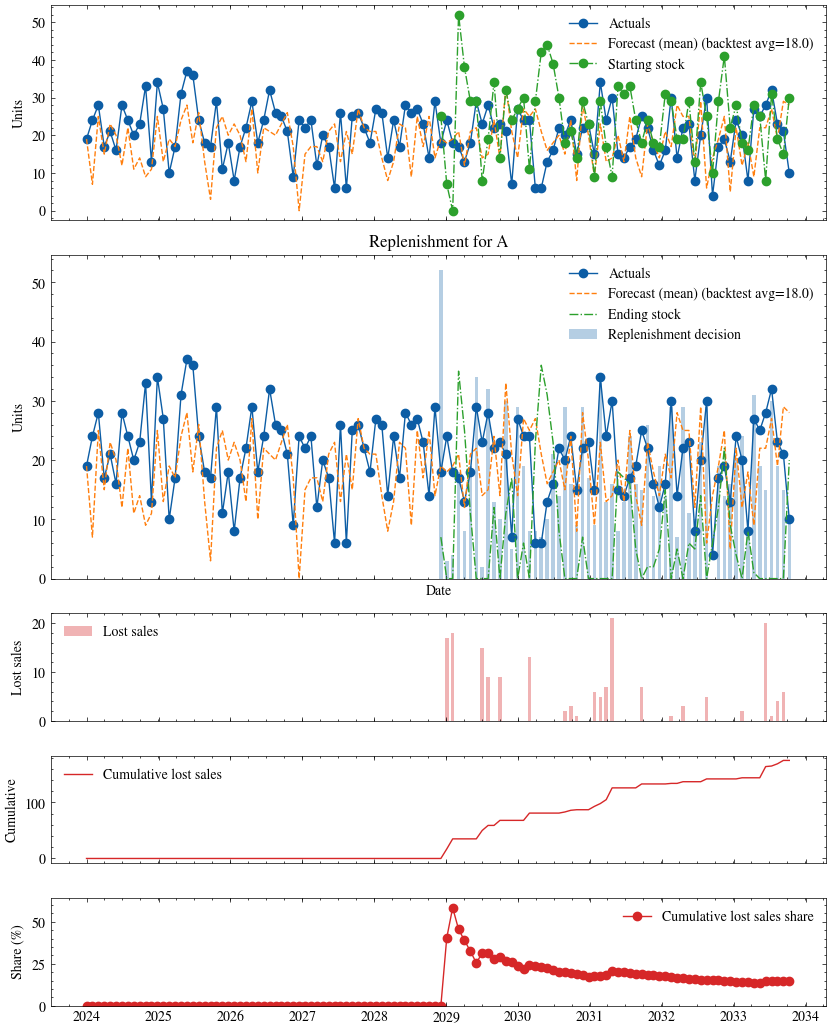

In [11]:
example_id = calibrated_decisions_df["unique_id"].iloc[0]
plot_replenishment_decisions(rows_df, calibrated_decisions_df, unique_id=example_id)


In [12]:
sigma_decisions_df = replenishment_decision_rows_to_dataframe(eval_decisions)
sigma_decisions_df.head()


,unique_id,ds,quantity,demand,forecast_quantity,forecast_quantity_lead_time,reorder_point,order_up_to,incoming_stock,starting_stock,...,current_stock,on_order,backorders,missed_sales,sigma,aggregation_window,review_period,forecast_horizon,rmse_window,percentile_target
0,A,2028-12-05,52,18,19,21,83.330266,102.330266,0,25,...,7,52,0,0,0.99,1,1,1,1,None
1,A,2029-01-04,3,24,18,12,86.199101,104.199101,0,7,...,0,55,0,17,0.99,1,1,1,1,None
2,A,2029-02-03,4,18,19,21,79.818053,98.818053,0,0,...,0,59,0,18,0.99,1,1,1,1,None
3,A,2029-03-05,18,17,21,22,81.450151,102.450151,52,52,...,35,25,0,0,0.99,1,1,1,1,None
4,A,2029-04-04,8,13,12,14,83.460974,95.460974,3,38,...,25,30,0,0,0.99,1,1,1,1,None


<Axes: title={'center': 'Replenishment for A'}, xlabel='Date', ylabel='Units'>

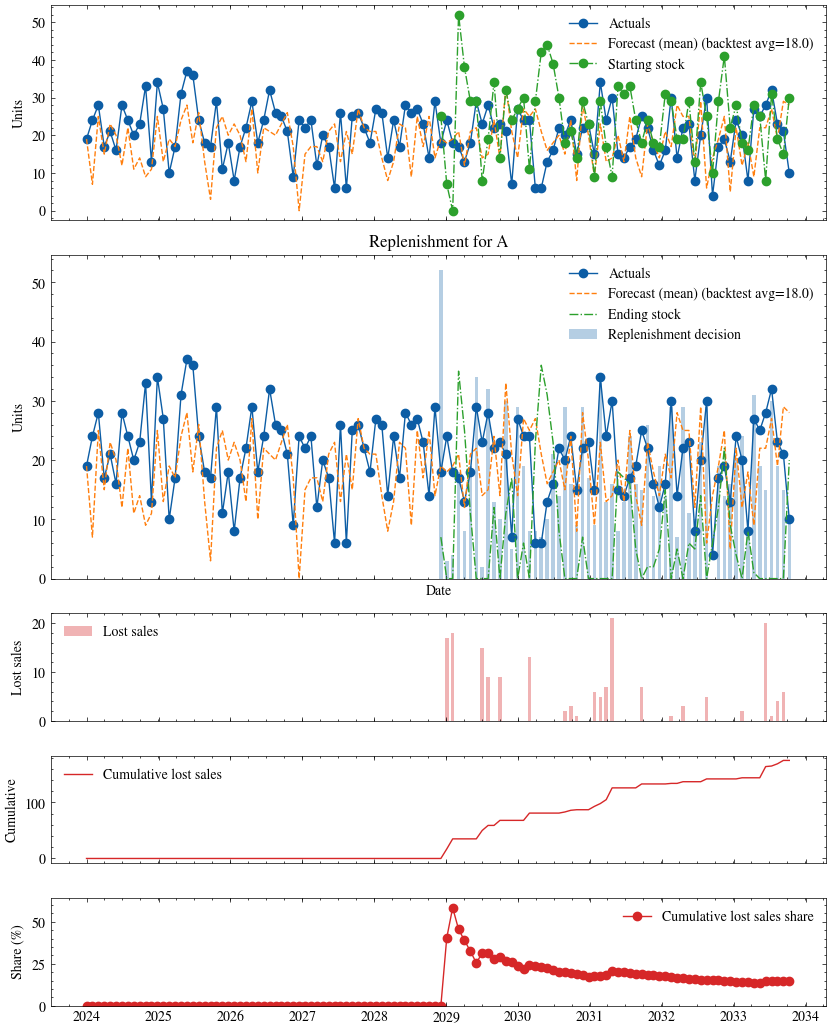

In [13]:
example_id = sigma_decisions_df["unique_id"].iloc[0]
plot_replenishment_decisions(rows_df, sigma_decisions_df, unique_id=example_id)


## 3) Optimize Sigma + Aggregation Window


In [15]:
backtest_rmse = compute_backtest_rmse_by_article(backtest_rows, rmse_window=rmse_window)

point_configs = build_point_forecast_article_configs_from_standard_rows(
    backtest_rows,
    service_level_factor=.95,
    service_level_mode="fill_rate",
    fixed_rmse=backtest_rmse,
    review_period=review_period,
    forecast_horizon=forecast_horizon,
    rmse_window=rmse_window,
)

agg_sigma_result = optimize_aggregation_and_service_level_factors(
    point_configs,
    candidate_windows=candidate_windows,
    candidate_factors=candidate_service_levels,
    service_level_mode="fill_rate",
)
agg_best_factors = {
    unique_id: result.service_level_factor
    for unique_id, result in agg_sigma_result.items()
}
agg_windows = {
    unique_id: result.window
    for unique_id, result in agg_sigma_result.items()
}

agg_backtest_rmse = compute_backtest_rmse_by_article(
    backtest_rows,
    aggregation_window=agg_windows,
    rmse_window=rmse_window,
)

forecast_point_configs = build_point_forecast_article_configs_from_standard_rows(
    evaluation_rows,
    service_level_factor=agg_best_factors,
    service_level_mode="fill_rate",
    fixed_rmse=agg_backtest_rmse,
    actuals_override=backtest_actuals,
    review_period=agg_windows,
    forecast_horizon=agg_windows,
    rmse_window=agg_windows,
)
agg_simulations = {
    unique_id: simulate_replenishment_with_aggregation(
        periods=config.periods,
        demand=config.demand,
        initial_on_hand=config.initial_on_hand,
        lead_time=config.lead_time,
        policy=config.policy,
        aggregation_window=agg_windows[unique_id],
        holding_cost_per_unit=config.holding_cost_per_unit,
        stockout_cost_per_unit=config.stockout_cost_per_unit,
        order_cost_per_order=config.order_cost_per_order,
        order_cost_per_unit=config.order_cost_per_unit,
    )
    for unique_id, config in forecast_point_configs.items()
}
agg_decisions = build_replenishment_decisions_from_simulations(
    evaluation_rows,
    agg_simulations,
    aggregation_window=agg_windows,
    sigma=agg_best_factors,
    fixed_rmse=agg_backtest_rmse,
    service_level_mode="fill_rate",
    review_period=agg_windows,
    forecast_horizon=agg_windows,
    rmse_window=agg_windows,
)


In [16]:
agg_decisions_df = replenishment_decision_rows_to_dataframe(agg_decisions)
agg_decisions_df.head()


,unique_id,ds,quantity,demand,forecast_quantity,forecast_quantity_lead_time,reorder_point,order_up_to,incoming_stock,starting_stock,...,current_stock,on_order,backorders,missed_sales,sigma,aggregation_window,review_period,forecast_horizon,rmse_window,percentile_target
0,A,2028-12-05,87,18,18.666667,18.000000,88.122353,144.122353,0,25,...,7,87,0,0,0.99,3,3,3,3,None
1,A,2029-01-04,0,24,19.333333,18.333333,89.802810,147.802810,0,7,...,0,87,0,17,0.99,3,3,3,3,None
2,A,2029-02-03,0,18,17.333333,19.000000,83.593870,135.593870,0,0,...,0,87,0,18,0.99,3,3,3,3,None
3,A,2029-03-05,21,17,18.000000,17.000000,84.402676,138.402676,87,87,...,70,21,0,0,0.99,3,3,3,3,None
4,A,2029-04-04,0,13,18.333333,17.666667,85.498135,140.498135,0,70,...,57,21,0,0,0.99,3,3,3,3,None


<Axes: title={'center': 'Replenishment for A'}, xlabel='Date', ylabel='Units'>

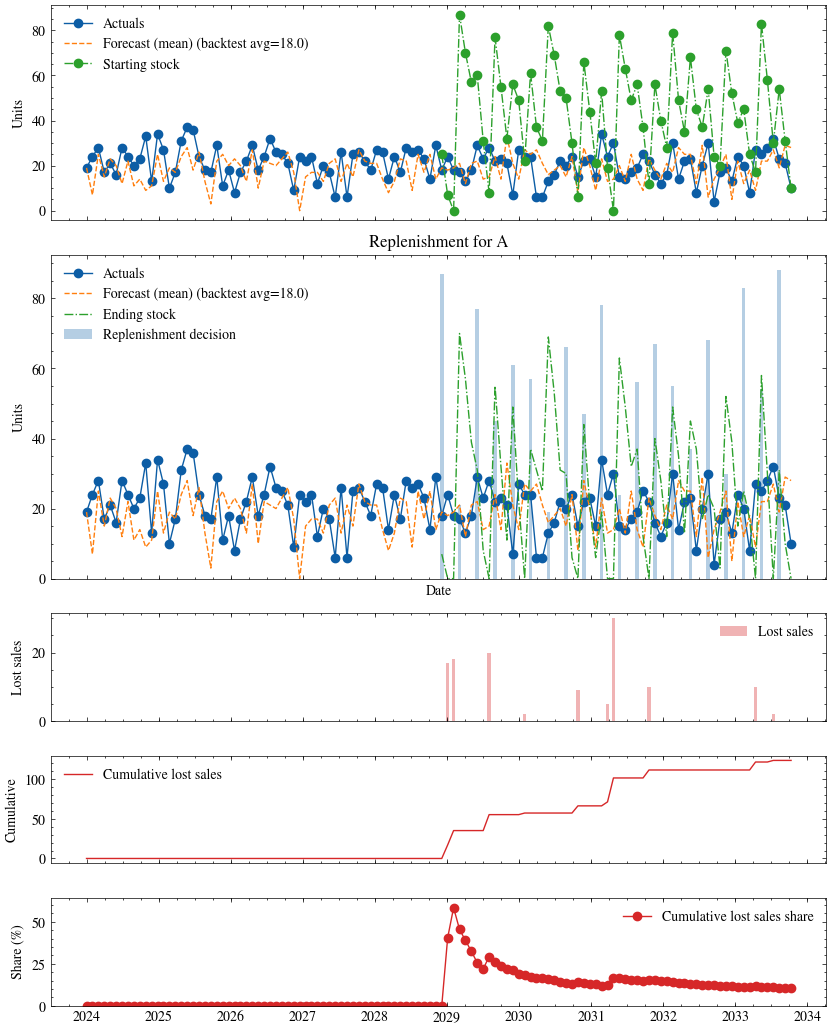

In [17]:
example_id = agg_decisions_df["unique_id"].iloc[0]
plot_replenishment_decisions(rows_df, agg_decisions_df, unique_id=example_id)


### Take a given fill rate and optimize aggregation windows

In [19]:
backtest_rmse = compute_backtest_rmse_by_article(backtest_rows, rmse_window=rmse_window)

point_configs = build_point_forecast_article_configs_from_standard_rows(
    backtest_rows,
    service_level_factor=.95,
    service_level_mode="fill_rate",
    fixed_rmse=backtest_rmse,
    review_period=review_period,
    forecast_horizon=forecast_horizon,
    rmse_window=rmse_window,
)

agg_sigma_result = optimize_aggregation_and_service_level_factors(
    point_configs,
    candidate_windows=candidate_windows,
    candidate_factors=[.95],
    service_level_mode="fill_rate",
)
agg_best_factors = {
    unique_id: result.service_level_factor
    for unique_id, result in agg_sigma_result.items()
}
agg_windows = {
    unique_id: result.window
    for unique_id, result in agg_sigma_result.items()
}

agg_backtest_rmse = compute_backtest_rmse_by_article(
    backtest_rows,
    aggregation_window=agg_windows,
    rmse_window=rmse_window,
)

forecast_point_configs = build_point_forecast_article_configs_from_standard_rows(
    evaluation_rows,
    service_level_factor=agg_best_factors,
    service_level_mode="fill_rate",
    fixed_rmse=agg_backtest_rmse,
    actuals_override=backtest_actuals,
    review_period=agg_windows,
    forecast_horizon=agg_windows,
    rmse_window=agg_windows,
)
agg_simulations = {
    unique_id: simulate_replenishment_with_aggregation(
        periods=config.periods,
        demand=config.demand,
        initial_on_hand=config.initial_on_hand,
        lead_time=config.lead_time,
        policy=config.policy,
        aggregation_window=agg_windows[unique_id],
        holding_cost_per_unit=config.holding_cost_per_unit,
        stockout_cost_per_unit=config.stockout_cost_per_unit,
        order_cost_per_order=config.order_cost_per_order,
        order_cost_per_unit=config.order_cost_per_unit,
    )
    for unique_id, config in forecast_point_configs.items()
}
agg_decisions = build_replenishment_decisions_from_simulations(
    evaluation_rows,
    agg_simulations,
    aggregation_window=agg_windows,
    sigma=agg_best_factors,
    fixed_rmse=agg_backtest_rmse,
    service_level_mode="fill_rate",
    review_period=agg_windows,
    forecast_horizon=agg_windows,
    rmse_window=agg_windows,
)


,unique_id,ds,quantity,demand,forecast_quantity,forecast_quantity_lead_time,reorder_point,order_up_to,incoming_stock,starting_stock,...,current_stock,on_order,backorders,missed_sales,sigma,aggregation_window,review_period,forecast_horizon,rmse_window,percentile_target
0,A,2028-12-05,68,18,18.666667,18.000000,66.720082,122.720082,0,25,...,7,68,0,0,0.95,3,3,3,3,None
1,A,2029-01-04,0,24,19.333333,18.333333,68.269214,126.269214,0,7,...,0,68,0,17,0.95,3,3,3,3,None
2,A,2029-02-03,0,18,17.333333,19.000000,61.973617,113.973617,0,0,...,0,68,0,18,0.95,3,3,3,3,None
3,A,2029-03-05,22,17,18.000000,17.000000,62.276155,116.276155,68,68,...,51,22,0,0,0.95,3,3,3,3,None
4,A,2029-04-04,0,13,18.333333,17.666667,63.412967,118.412967,0,51,...,38,22,0,0,0.95,3,3,3,3,None


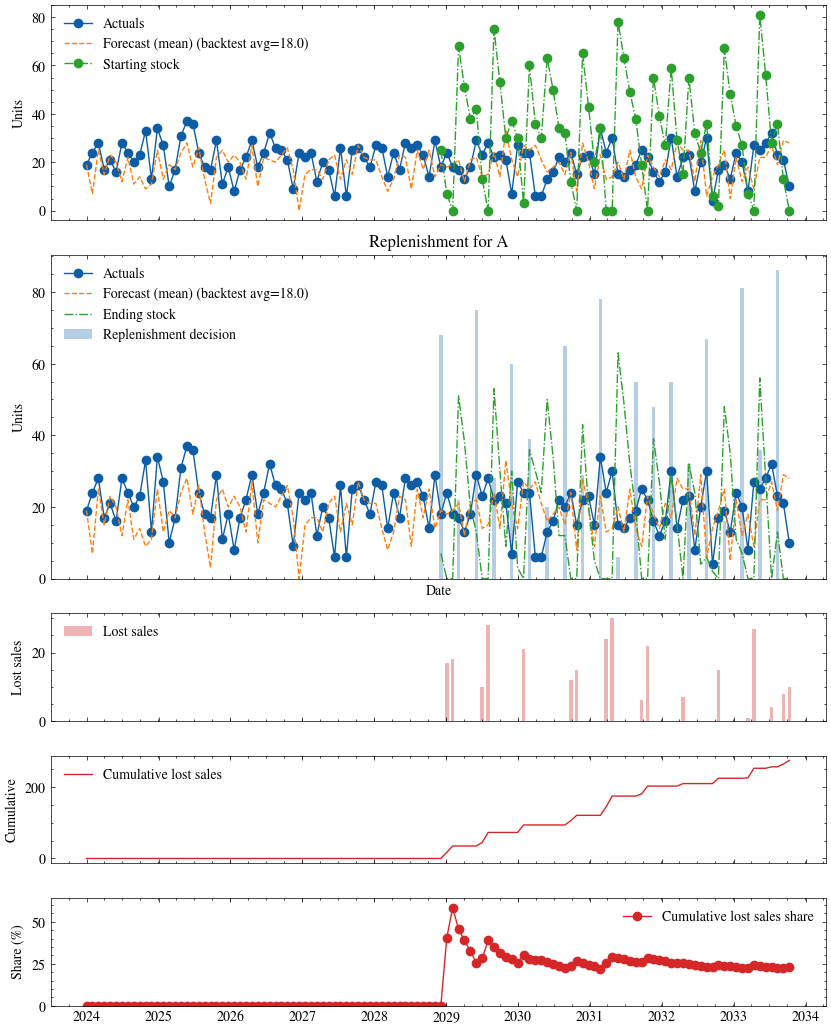

In [20]:
agg_decisions_df = replenishment_decision_rows_to_dataframe(agg_decisions)

example_id = agg_decisions_df["unique_id"].iloc[0]
plot_replenishment_decisions(rows_df, agg_decisions_df, unique_id=example_id)

agg_decisions_df.head()